<a href="https://colab.research.google.com/github/fhsu4976/CS598/blob/main/cs598ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/DLH/')

Drive already mounted at /DLH/; to attempt to forcibly remount, call drive.mount("/DLH/", force_remount=True).


# Query-Focused EHR Summarization Reproduction (MIMIC-III subset, All 3 model variations)

# --- 1. Install Required Libraries ---

In [2]:
!pip install transformers datasets scikit-learn spacy matplotlib --quiet
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# --- 2. Import Packages ---

In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import os
import json
import gzip
import json
import psutil
import pickle

# --- 3. Set Device ---

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- 4. Load Preprocessed MIMIC-III Subset ---

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import os
import json
import gzip
import json
import psutil
import csv
import random
from typing import List, Dict
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def log_memory(note):
    mem = psutil.virtual_memory()
    used = mem.used / (1024**3)
    print(f"[RAM] {note}: {used:.2f} GB used")

DATA_PATH = "/DLH/MyDrive/DLH"
SAMPLE_SIZE = 5
SEED = 42

# 1) allow arbitrarily large fields
csv.field_size_limit(sys.maxsize)

def load_random_csv_samples(
    filepath: str,
    sample_size: int = 10,
    seed: int = None
) -> List[Dict[str, str]]:
    """
    Reservoir-sample `sample_size` rows from a (possibly gzipped) CSV file.
    Each row is returned as a dict keyed by the top-level columns.
    """
    if seed is not None:
        random.seed(seed)

    # 2) peek at the first two bytes to see if it’s gzipped
    with open(filepath, "rb") as f:
        magic = f.read(2)
    opener = gzip.open if magic == b"\x1f\x8b" else open

    reservoir: List[Dict[str, str]] = []
    with opener(filepath, mode="rt", encoding="utf-8", errors="replace", newline="") as f:
        reader = csv.DictReader(f)  # uses the header row: reports,future_reports,targets,labels,all_codes,timepoint
        for idx, row in enumerate(reader):
            if idx < sample_size:
                reservoir.append(row)
            else:
                j = random.randrange(idx + 1)
                if j < sample_size:
                    reservoir[j] = row

    return reservoir


train_data = load_random_csv_samples(f"{DATA_PATH}/train.data", sample_size=SAMPLE_SIZE, seed=SEED)
samples   = load_random_csv_samples(f"{DATA_PATH}/val.data",   sample_size=SAMPLE_SIZE, seed=SEED)
test_data  = load_random_csv_samples(f"{DATA_PATH}/test.data",  sample_size=SAMPLE_SIZE, seed=SEED)

for i, row in enumerate(samples, 1):
    print(f"--- Sample #{i} (timepoint={row['timepoint']}) ---")
    # just show the first 80 chars of each big field
    for col in ["reports", "future_reports", "targets", "labels", "all_codes"]:
        snippet = row[col].replace("\n", " ")[:80]
        print(f"{col[:12]:12}: {snippet!r}…")
    print()

# sanity-check your keys
print("Keys in one sample:", list(test_data[0].keys()))
# now this will work:
patient_sentences = {item["patient_id"]: item["sentences"] for item in test_data}
queries = test_data[0]["queries"]
print(patient_sentences, queries)

nlp = spacy.load("en_core_web_sm")
log_memory("After spaCy load")

patient_sentences = {item["patient_id"]: item["sentences"] for item in test_data}
queries = test_data[0]["queries"]
query_descriptions = {q: q.replace("_", " ") for q in queries.keys()}


--- Sample #1 (timepoint=2160-05-22) ---
reports     : 'patient_id,hadm_id,date,report_type,description,text,from_table,other_info 3178,'…
future_repor: 'patient_id,hadm_id,date,report_type,description,text,from_table,other_info 3178,'…
targets     : '["(\'ICD10\', \'N179\')", "(\'ICD10\', \'M109\')", "(\'ICD10\', \'T782XXA\')", "(\'ICD10\', \'T'…
labels      : '[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1'…
all_codes   : 'patient_id,hadm_id,date,flag,name,code_type,code,from_table,other_info 3178,1238'…

--- Sample #2 (timepoint=2127-09-24) ---
reports     : 'patient_id,hadm_id,date,report_type,description,text,from_table,other_info 24074'…
future_repor: 'patient_id,hadm_id,date,report_type,description,text,from_table,other_info 24074'…
targets     : '["(\'ICD10\', \'Z950\')", "(\'ICD10\', \'I4\')", "(\'ICD10\', \'Z\')", "(\'ICD10\', \'I50\')", "'…
labels      : '[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0'…
all_

KeyError: 'patient_id'

# --- 5. Initialize Tokenizer and ClinicalBERT ---

In [ ]:
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# --- 6. Helper Functions ---

In [ ]:
def get_sentence_embeddings(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # CLS token


# --- 7. Baseline 1: TF-IDF Cosine Similarity ---

In [ ]:
all_sentences = sum(patient_sentences.values(), [])
tfidf = TfidfVectorizer().fit(all_sentences + list(query_descriptions.values()))

def tfidf_similarity(sentences, query):
    sent_vecs = tfidf.transform(sentences)
    query_vec = tfidf.transform([query_descriptions[query]])
    return cosine_similarity(sent_vecs, query_vec).squeeze()


# --- 8. Baseline 2: ClinicalBERT Cosine Similarity ---

In [ ]:
def clinicalbert_cosine_similarity(sentences, query):
    sentence_embeds = get_sentence_embeddings(sentences)
    query_embed = get_sentence_embeddings([query_descriptions[query]])
    sims = torch.nn.functional.cosine_similarity(sentence_embeds, query_embed)
    return sims.cpu().numpy()


# --- 9. Distantly Supervised Extractive Model ---

In [ ]:
class AttentionExtractor(nn.Module):
    def __init__(self, query_embed_type='indicator'):
        super().__init__()
        self.query_embed_type = query_embed_type
        self.hidden_size = 768
        self.proj = nn.Linear(self.hidden_size, 64)
        self.query_proj = nn.Linear(self.hidden_size, 64)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, sentence_embeds, query_embeds):
        s_proj = self.proj(sentence_embeds)
        q_proj = self.query_proj(query_embeds)
        attn_scores = torch.matmul(s_proj, q_proj.t()).squeeze()
        attn_weights = torch.softmax(attn_scores, dim=0)
        context = torch.sum(attn_weights.unsqueeze(-1) * s_proj, dim=0)
        combined = torch.cat([context, q_proj.squeeze()], dim=-1)
        out = self.fc(combined)
        return out.squeeze(), attn_weights


# --- 10. Training Loop (Tiny Demo) ---

In [ ]:
def train_model(query_embed_type='indicator', epochs=15):
    model = AttentionExtractor(query_embed_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for pid, sentences in patient_sentences.items():
            labels = torch.tensor([queries.get(query, 0) for query in queries]).float().to(device)
            sentence_embeds = get_sentence_embeddings(sentences)
            for i, query in enumerate(queries):
                if query_embed_type == 'indicator':
                    one_hot = torch.eye(len(queries))[i].unsqueeze(0).to(device)  # (1,3)
                    query_embed = one_hot.repeat(1, 768 // len(queries))  # Expand to (1,768)
                elif query_embed_type == 'description':
                    query_embed = get_sentence_embeddings([query_descriptions[query]])
                elif query_embed_type == 'hierarchy':
                    query_embed = get_sentence_embeddings([" > ".join(["Diagnosis", query])])
                pred, _ = model(sentence_embeds, query_embed)
                pred = pred.unsqueeze(0)
                loss = loss_fn(pred, labels[i].unsqueeze(0))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    return model


# --- 11. Evaluate Models ---

In [ ]:
def evaluate_attention_model(model, query_embed_type):
    model.eval()
    y_true = []
    y_scores = []
    for pid, sentences in patient_sentences.items():
        sentence_embeds = get_sentence_embeddings(sentences)
        for i, query in enumerate(queries):
            if query_embed_type == 'indicator':
                query_embed = torch.eye(len(queries))[i].unsqueeze(0).to(device)
            elif query_embed_type == 'description':
                query_embed = get_sentence_embeddings([query_descriptions[query]])
            elif query_embed_type == 'hierarchy':
                query_embed = get_sentence_embeddings([" > ".join(["Diagnosis", query])])
            pred, attn_weights = model(sentence_embeds, query_embed)
            y_true.append(queries[query])
            y_scores.append(pred.item())
    auc = roc_auc_score(y_true, y_scores)
    print(f"AUROC: {auc:.4f}")
    return y_true, y_scores


# --- 12. Run Everything ---

In [ ]:
print("Training Indicator model...")
model_indicator = train_model('indicator')
print("Training Description model...")
model_description = train_model('description')
print("Training Hierarchy model...")
model_hierarchy = train_model('hierarchy')

# Evaluate
print("\nEvaluation Results")
y_true, y_scores = evaluate_attention_model(model_hierarchy, 'hierarchy')


Training Indicator model...
Epoch 1, Loss: 6.0175
Epoch 2, Loss: 5.9164
Epoch 3, Loss: 5.8232
Epoch 4, Loss: 5.7361
Epoch 5, Loss: 5.6523
Epoch 6, Loss: 5.5714
Epoch 7, Loss: 5.4935
Epoch 8, Loss: 5.4208
Epoch 9, Loss: 5.3524
Epoch 10, Loss: 5.2851
Epoch 11, Loss: 5.2183
Epoch 12, Loss: 5.1527
Epoch 13, Loss: 5.0879
Epoch 14, Loss: 5.0241
Epoch 15, Loss: 4.9607
Training Description model...
Epoch 1, Loss: 6.2635
Epoch 2, Loss: 6.2280
Epoch 3, Loss: 6.1986
Epoch 4, Loss: 6.1694
Epoch 5, Loss: 6.1411
Epoch 6, Loss: 6.1131
Epoch 7, Loss: 6.0853
Epoch 8, Loss: 6.0582
Epoch 9, Loss: 6.0309
Epoch 10, Loss: 6.0028
Epoch 11, Loss: 5.9736
Epoch 12, Loss: 5.9444
Epoch 13, Loss: 5.9157
Epoch 14, Loss: 5.8869
Epoch 15, Loss: 5.8581
Training Hierarchy model...
Epoch 1, Loss: 6.3609
Epoch 2, Loss: 6.3216
Epoch 3, Loss: 6.2913
Epoch 4, Loss: 6.2637
Epoch 5, Loss: 6.2374
Epoch 6, Loss: 6.2124
Epoch 7, Loss: 6.1880
Epoch 8, Loss: 6.1645
Epoch 9, Loss: 6.1421
Epoch 10, Loss: 6.1206
Epoch 11, Loss: 6.099

# --- 13. Plot PR Curve ---

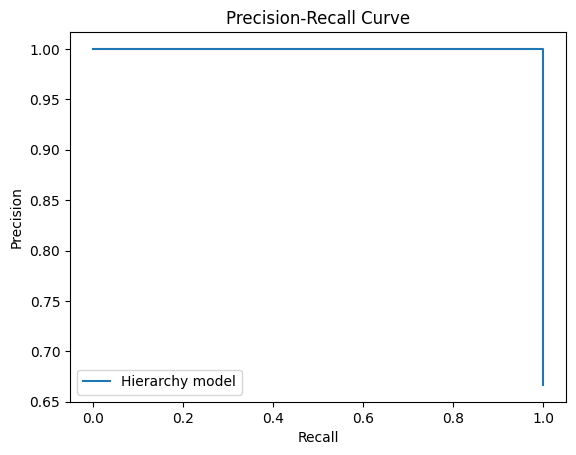

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision, label='Hierarchy model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
